# Analysis to deconvolve proximal/distal Fallopian tube bulk mRNA-seq data with published distal Fallopian tube single-cell mRNA-seq data 

In [1]:
# making a list of file paths the system uses
links = [line.strip().split() for line in open('../system_dirs.txt')]

In [2]:
#prep notebook
import scanpy as sc
import bbknn
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sns
from gprofiler import GProfiler
#import phate

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import os
os.environ['R_HOME'] = links[0][0]

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
#%load_ext rmagic
#%load_ext rpy2.ipython
import anndata2ri

In [3]:
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR) # quiter outputs

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

sc.logging.print_versions()

scanpy==1.4.5.post3 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==0.24.1 scikit-learn==0.22.1 statsmodels==0.11.0 python-igraph==0.7.1 louvain==0.6.1


In [4]:
R_version = links[1][0]

In [5]:
%%R -i R_version 
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(new = R_version) #oooh, or is it maybe R that is the problem?
#.libPaths(new='/home/ian/anaconda3/envs/Py3_Env/lib/R/library')


# Load all the R libraries we will be using in the notebook
library(slam)
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)
library(MuSiC)
library(TED)

#also useful
library(SingleR)
library(scRNAseq)
library(scater) #this is critical
library(org.Hs.eg.db)
library(purrr)

hs<-org.Hs.eg.db

# Process Raw Hu data
- https://github.com/zhiyhu/scFT-paper 

In [6]:
# let's make a scanpy object from the count data that Hu's group put on GEO
counts = links[2][0]
adata = sc.read(counts, delimiter='\t', first_column_names=True) 
adata = adata.T.copy()
adata

AnnData object with n_obs × n_vars = 3877 × 22110 

# Filtering

In [7]:
# annotate anndata object
adata.obs['individual'] = [i[0:5] for i in adata.obs.index] #add individual
adata.var['gene_ids'] = adata.var.index #pick gene IDs
adata

AnnData object with n_obs × n_vars = 3877 × 22110 
    obs: 'individual'
    var: 'gene_ids'

In [8]:
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']

In [9]:
#let's add information about fresh fallopian tube or not
fresh=tuple(['11543','11545','15066','11553','15072','15091'])
adata.obs['fresh']=['fresh' if i[0:5] in fresh else 'not_fresh' for i in adata.obs.index]
adata.obs['tube_side']=['left' if i[5].upper()=='L' else 'right' for i in adata.obs.index]
adata.obs['sample']=[i.split('-')[0] for i in adata.obs.index]
adata.obs.head()

individual  n_counts  log_counts  n_genes  mt_frac      fresh  \
11519L-P1-E10      11519  460763.0   13.040639     1740      0.0  not_fresh   
11519L-P1-F02      11519  542911.0   13.204700     2970      0.0  not_fresh   
11519L-P1-F03      11519  396958.0   12.891585     3259      0.0  not_fresh   
11519L-P1-F06      11519  622565.0   13.341603     5033      0.0  not_fresh   
11519L-P1-F07      11519  499673.0   13.121709     4165      0.0  not_fresh   

              tube_side  sample  
11519L-P1-E10      left  11519L  
11519L-P1-F02      left  11519L  
11519L-P1-F03      left  11519L  
11519L-P1-F06      left  11519L  
11519L-P1-F07      left  11519L

... storing 'individual' as categorical
... storing 'fresh' as categorical
... storing 'tube_side' as categorical
... storing 'sample' as categorical


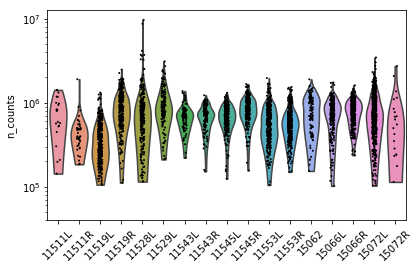

In [10]:
# plot the counts for each cell in each sample
t1=sc.pl.violin(adata, 'n_counts',groupby='sample', size=2, log=True, cut=0, rotation=45)

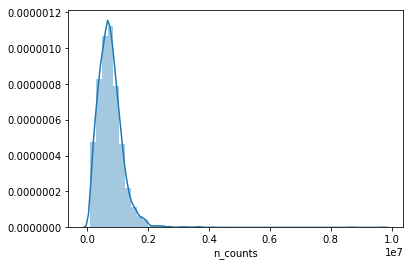

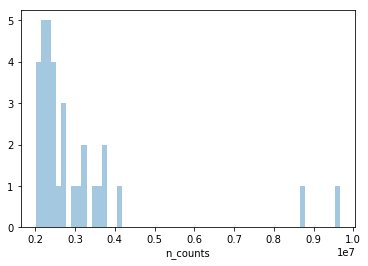

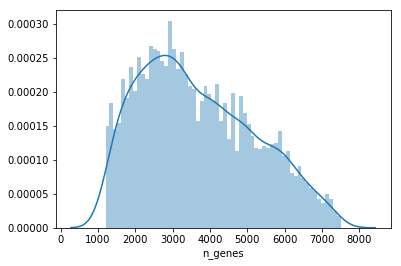

In [11]:
# find resonable count cutoffs
p3 = sns.distplot(adata.obs['n_counts'], kde=True)
plt.show()

p5 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']>2000000], kde=False, bins=60)
plt.show()

p6 = sns.distplot(adata.obs['n_genes'], kde=True, bins=60)
plt.show()

In [12]:
# set cell quality cutoffs
sc.pp.filter_cells(adata, min_genes = 500)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

sc.pp.filter_genes(adata, min_cells=3)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Number of cells after gene filter: 3877
Number of genes after cell filter: 20726
Number of cells after gene filter: 3877


# Cluster resolution

In [13]:
cluster_resolution=1.25 #1.1 #immune cells drop off #1.25 #1.5 #2 #2 best so far #1 #5 #0.3 # 1

# Normalization/Batch Correction
- I will employ BBKNN in the normalization and also use BBKNN for batch correction

In [14]:
n_pcs=21

## BBKNN setup 

In [15]:
#make anpther a data object to manipulate
adata_pp = adata.copy()

In [16]:
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)

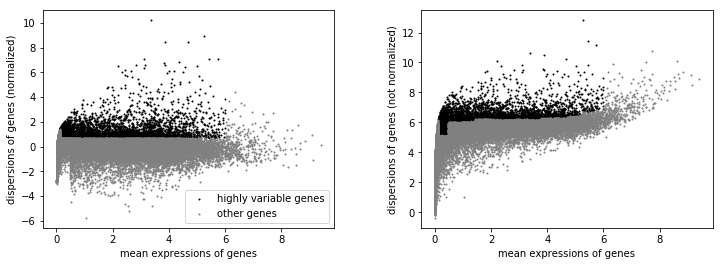

[3734, 20726]


In [17]:
filter_result = sc.pp.filter_genes_dispersion(adata_pp.X, 
                                              min_mean=0.125,
                                              max_mean=6,
                                              min_disp=0.7)

sc.pl.filter_genes_dispersion(filter_result)
print([sum([i[0] for i in filter_result]),len(filter_result)])

/home/ian/anaconda3/envs/SC_Env_JIC/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:298: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


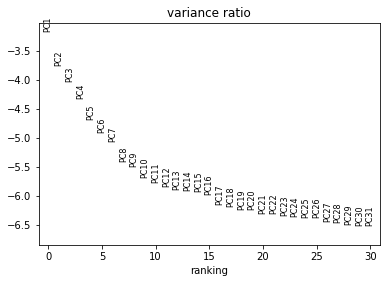

In [18]:
adata_pp = adata_pp[:, filter_result.gene_subset]
sc.pp.log1p(adata_pp, base=2)
sc.pp.scale(adata_pp, max_value=10)
sc.tl.pca(adata_pp)
adata_pp.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
sc.pl.pca_variance_ratio(adata_pp, log=True)

In [19]:
#help(sc.pp.neighbors)

In [20]:
adata_neighbors=adata_pp.copy()

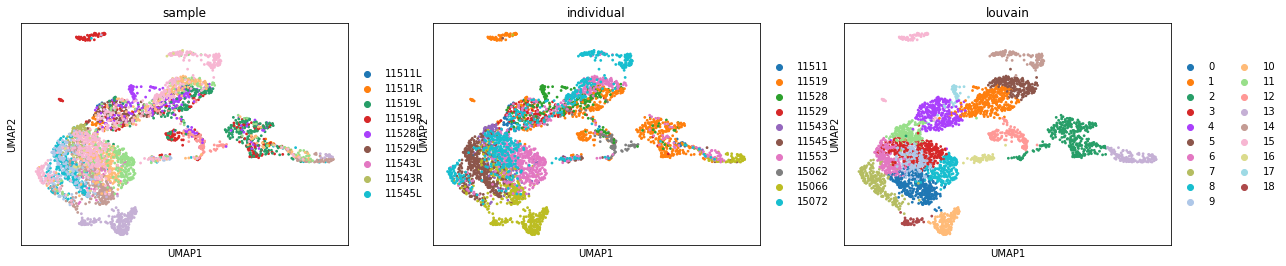

In [21]:
sc.pp.neighbors(adata_neighbors,n_pcs=n_pcs, n_neighbors=20) # default neighbors is 15, smaller numbers better preserve local structure, should be < 100
sc.tl.umap(adata_neighbors)
sc.tl.louvain(adata_neighbors, resolution=cluster_resolution)

sc.pl.umap(adata_neighbors, color=['sample','individual','louvain'])

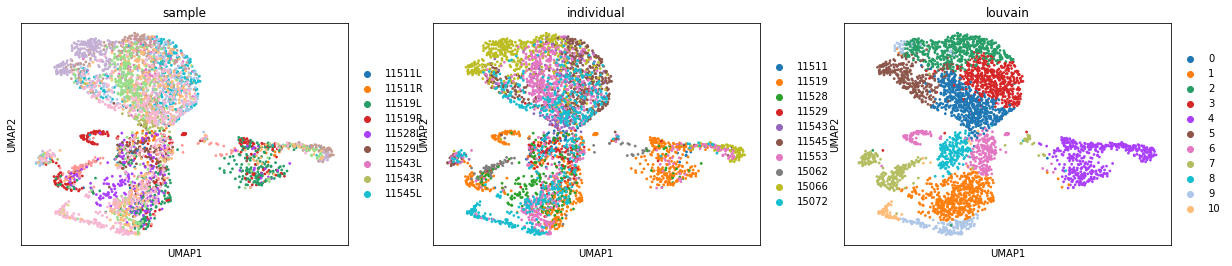

In [22]:
adata_bbknn_trim = bbknn.bbknn(adata_pp,
                               neighbors_within_batch=5,
                               batch_key='sample',
                               n_pcs=n_pcs,
                               trim=50,
                               copy=True)
sc.tl.umap(adata_bbknn_trim)
sc.tl.louvain(adata_bbknn_trim, resolution= cluster_resolution)

sc.pl.umap(adata_bbknn_trim, color=['sample','individual','louvain'])

In [23]:
adata_pp #3875 highly variable genes

AnnData object with n_obs × n_vars = 3877 × 3734 
    obs: 'individual', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'fresh', 'tube_side', 'sample'
    var: 'gene_ids', 'n_cells'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [24]:
#Preprocess variables for scran normalization
#this has many ep w/ no smooth muscle
input_groups = adata_bbknn_trim.obs['sample'] 
adata.uns['neighbors']=adata_bbknn_trim.uns['neighbors']

#input_groups = adata_bbknn.obs['sample'] 
#adata.uns['neighbors']=adata_bbknn.uns['neighbors']

data_mat = adata.X.T

In [25]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

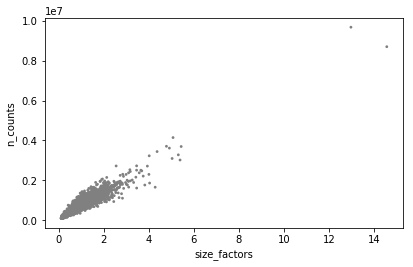

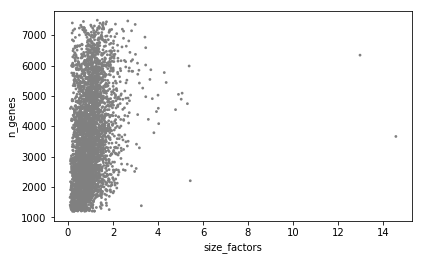

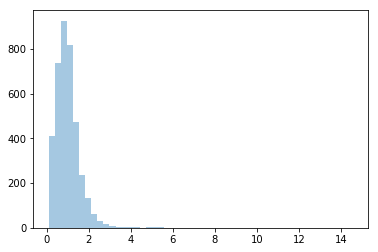

In [26]:
# Visualize the estimated size factors
#are these plots better with only fresh cells?
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sns.distplot(size_factors, bins=50, kde=False)
plt.show()

In [27]:
adata.layers["counts"] = adata.X.copy()

In [28]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [29]:
# add highly variable
adata.var['highly_variable'] = filter_result.gene_subset

In [30]:
sc.tl.pca(adata, n_comps = 50, use_highly_variable = True, svd_solver = 'arpack')
sc.tl.louvain(adata, key_added = 'clusters', resolution = cluster_resolution) 
sc.tl.umap(adata, n_components = 3)

### Batch corrected UMAPs

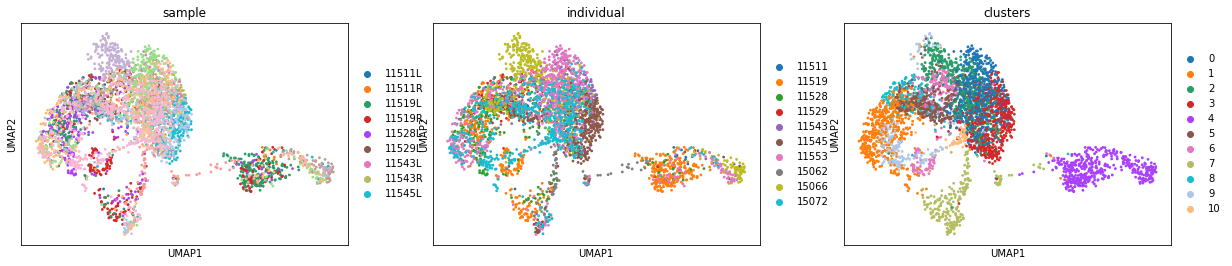

In [31]:
sc.pl.umap(adata, color=['sample','individual','clusters'])

# Cell cycle scoring

For cell cycle scoring, genes from Macosko et al., Cell 161 (2015) are used determine which cell cycle phase each cell is in

In [32]:
cell_cycle_genes = [x.strip() for x in open('regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

In [33]:
sc.tl.score_genes_cell_cycle(adata, s_genes=[i.upper() for i in s_genes], g2m_genes=[j.upper() for j in g2m_genes])

In [34]:
adata.obs['phase'].value_counts()

G1     2947
S       697
G2M     233
Name: phase, dtype: int64

It does not look like cell cycle should be regressed out

... storing 'phase' as categorical


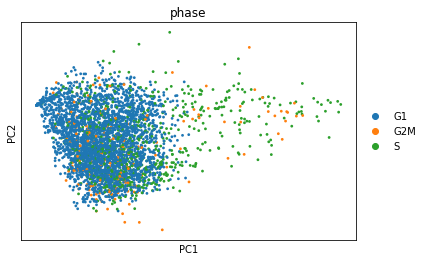

In [35]:
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
adata_cc_genes = adata[:, cell_cycle_genes].copy()
sc.pp.pca(adata_cc_genes, use_highly_variable=False, svd_solver='arpack')
sc.pl.pca_scatter(adata_cc_genes, color='phase', use_raw=False)

# Misc visualizations

In [36]:
sc.tl.umap(adata, n_components = 3) 
sc.tl.louvain(adata, key_added = 'clusters', resolution = cluster_resolution)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

... storing 'phase' as categorical


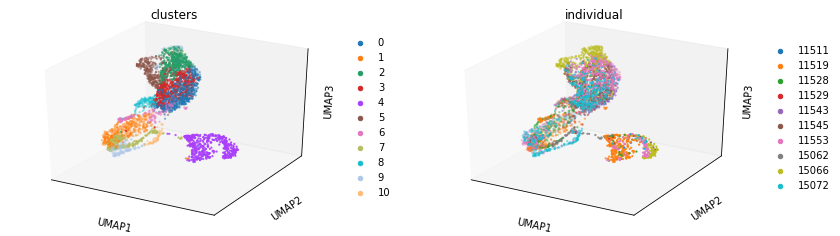

In [37]:
sc.pl.umap(adata, color=['clusters','individual'], use_raw=False, projection='3d')

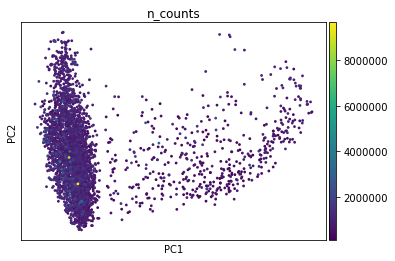

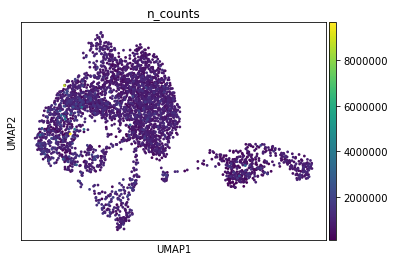

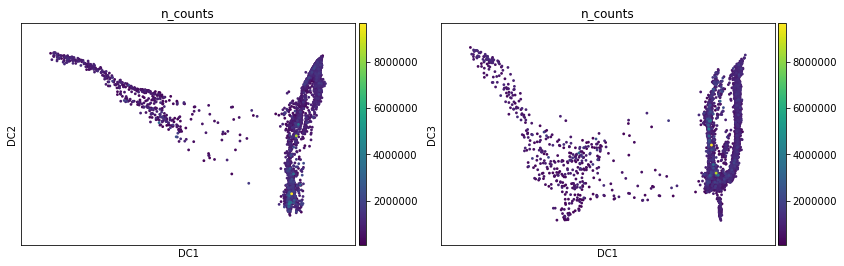

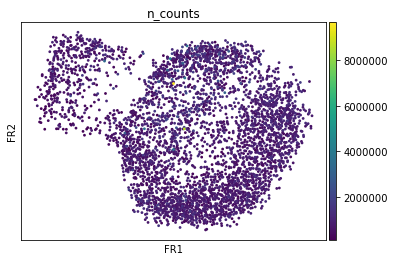

In [38]:
#count data does not seem to be driving variation in the data
sc.pl.pca_scatter(adata, color='n_counts') #so, 
sc.pl.umap(adata, color='n_counts')
sc.pl.diffmap(adata, color='n_counts', components=['1,2','1,3'])
sc.pl.draw_graph(adata, color='n_counts')

# Hu data sub-clustering

In [39]:
# Becasue I know that cluster 6 and 7 are smoothe muscle and t_cells, repectivley, I want to sub-cluster them
sc.tl.louvain(adata, restrict_to = ('clusters', ['6', '7']), resolution = 0.5,
              key_added='cell_type_subcluster')

In [40]:
adata.obs['cell_type_subcluster'].head()

11519L-P1-E10        4
11519L-P1-F02    6-7,0
11519L-P1-F03        4
11519L-P1-F06        1
11519L-P1-F07        1
Name: cell_type_subcluster, dtype: category
Categories (13, object): [0, 1, 2, 3, ..., 6-7,3, 8, 9, 10]

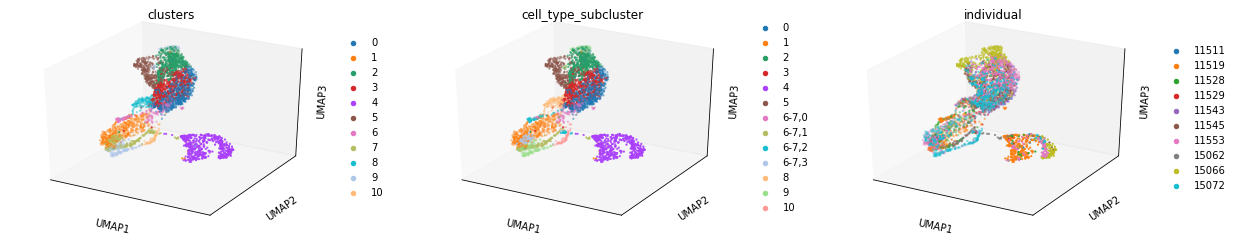

In [41]:
sc.pl.umap(adata, color = ['clusters','cell_type_subcluster','individual'], 
           use_raw=False, projection='3d')

# Call Cell Type

In [42]:
%%R

#ok, load in the data I will use as a refference
hpca.se <- HumanPrimaryCellAtlasData()
hpca.se

class: SummarizedExperiment 
dim: 19363 713 
metadata(0):
assays(1): logcounts
rownames(19363): A1BG A1BG-AS1 ... ZZEF1 ZZZ3
rowData names(0):
colnames(713): GSM112490 GSM112491 ... GSM92233 GSM92234
colData names(2): label.main label.fine


In [43]:
counts=pd.DataFrame(adata.X.T, columns = adata.obs.index, index = adata.var['gene_ids']) 
counts.head()

11519L-P1-E10  11519L-P1-F02  11519L-P1-F03  11519L-P1-F06  \
gene_ids                                                                   
WASH7P                  0.0            0.0            0.0            0.0   
LOC729737               0.0            0.0            0.0            0.0   
LOC100133331            0.0            0.0            0.0            0.0   
LOC100288069            0.0            0.0            0.0            0.0   
LINC00115               0.0            0.0            0.0            0.0   

              11519L-P1-F07  11519L-P1-F08  11519L-P1-F09  11519L-P1-F10  \
gene_ids                                                                   
WASH7P                  0.0            0.0            0.0            0.0   
LOC729737               0.0            0.0            0.0            0.0   
LOC100133331            0.0            0.0            0.0            0.0   
LOC100288069            0.0            0.0            0.0            0.0   
LINC00115               0.0            0.0            0.0            0.0   

              11519L-P1-F12  11519L-P1-G01  ...  15072R-p1-B05  15072R-p1-B06  \
gene_ids                                    ...                                 
WASH7P                  0.0            0.0  ...       0.000000            0.0   
LOC729737               0.0            0.0  ...       0.000000            0.0   
LOC100133331            0.0            0.0  ...       2.234774            0.0   
LOC100288069            0.0            0.0  ...       1.330109            0.0   
LINC00115               0.0            0.0  ...       0.000000            0.0   

              15072R-p1-B09  15072R-p1-B11  15072R-p1-B12  15072R-p1-B17  \
gene_ids                                                                   
WASH7P                  0.0            0.0       0.000000            0.0   
LOC729737               0.0            0.0       0.000000            0.0   
LOC100133331            0.0            0.0       0.000000            0.0   
LOC100288069            0.0            0.0       1.211929            0.0   
LINC00115               0.0            0.0       1.211929            0.0   

              15072R-p1-B18  15072R-p1-C01  15072R-p1-C02  15072R-p1-C03  
gene_ids                                                                  
WASH7P                  0.0       0.000000            0.0       0.000000  
LOC729737               0.0       0.000000            0.0       0.000000  
LOC100133331            0.0       0.000000            0.0       0.000000  
LOC100288069            0.0       0.000000            0.0       0.000000  
LINC00115               0.0       1.148038            0.0       4.313849  

[5 rows x 3877 columns]

In [44]:
r_adata = adata.X.T.copy()
%R -i r_adata

In [45]:
cluster_df=pd.DataFrame(adata.obs)
%R -i cluster_df

In [46]:
%%R

cluster_df<-data.frame(cluster_df)

In [47]:
#colnames and rownames for r_adata
r_adata_col = counts.columns
r_adata_row = counts.index

In [48]:
%%R -i r_adata_col,r_adata_row

colnames(r_adata)<-r_adata_col
rownames(r_adata)<-r_adata_row

In [49]:
%%R

test_set <- SummarizedExperiment(assays = list(counts = r_adata))

In [50]:
%%R

assays(test_set)$logcounts<-r_adata

- Here, I'm writing the R environment to a file which will be used by an R script with a different environment, because some of the R packages won't run in this environment 

In [51]:
R_save = links[3][0]

In [52]:
%%R -i R_save

save.image(file = R_save, version = NULL, safe = TRUE)

In [53]:
! conda run -n SC_Env Rscript run_singleR.R

Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    

In [54]:
R_load = links[4][0]

In [55]:
%%R -i R_load

load(R_load)

.libPaths(new = R_version)

library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)

#also useful
library(SingleR)
library(scRNAseq)
library(scater)
library(org.Hs.eg.db)
library(purrr)

In [56]:
%%R

x <- data.frame(test_celltype) # I could apply pruning function () to kick out low confidence labels pruneScores
rownames(x) #these are the clusters

 [1] "0"     "1"     "10"    "2"     "3"     "4"     "5"     "6-7,0" "6-7,1"
[10] "6-7,2" "6-7,3" "8"     "9"    


In [57]:
%%R

names(test_celltype)

[1] "scores"        "first.labels"  "tuning.scores" "labels"       
[5] "pruned.labels"


In [58]:
%%R

head(test_celltype$pruned.labels)

[1] "Epithelial_cells" "Epithelial_cells" "Epithelial_cells" "Epithelial_cells"
[5] "Epithelial_cells" "Epithelial_cells"


In [59]:
%%R

head(test_celltype$labels)

[1] "Epithelial_cells" "Epithelial_cells" "Epithelial_cells" "Epithelial_cells"
[5] "Epithelial_cells" "Epithelial_cells"


In [60]:
%R -o x

#cool, now make a dictionary for the cell type dict, then give that info to adata
celltype_dict=dict()
for i,j in zip(x.index, x['labels']): #this could be pruned labels
    celltype_dict[str(i)]=j
    
celltype_dict 

{'0': 'Epithelial_cells',
 '1': 'Epithelial_cells',
 '10': 'Epithelial_cells',
 '2': 'Epithelial_cells',
 '3': 'Epithelial_cells',
 '4': 'Epithelial_cells',
 '5': 'Epithelial_cells',
 '6-7,0': 'Epithelial_cells',
 '6-7,1': 'Smooth_muscle_cells',
 '6-7,2': 'T_cells',
 '6-7,3': 'Smooth_muscle_cells',
 '8': 'Epithelial_cells',
 '9': 'Epithelial_cells'}

In [61]:
for i,j in zip(x['labels'],x['pruned.labels']):
    if i!=j:
        print(i+' != '+j)

In [62]:
x['labels'].value_counts() 

Epithelial_cells       10
Smooth_muscle_cells     2
T_cells                 1
Name: labels, dtype: int64

In [63]:
adata.obs['cell_type']=[celltype_dict[i] for i in adata.obs['cell_type_subcluster']]

... storing 'cell_type' as categorical


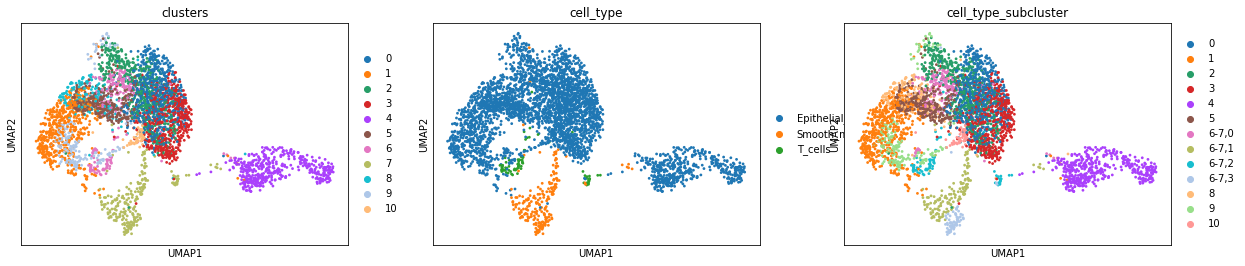

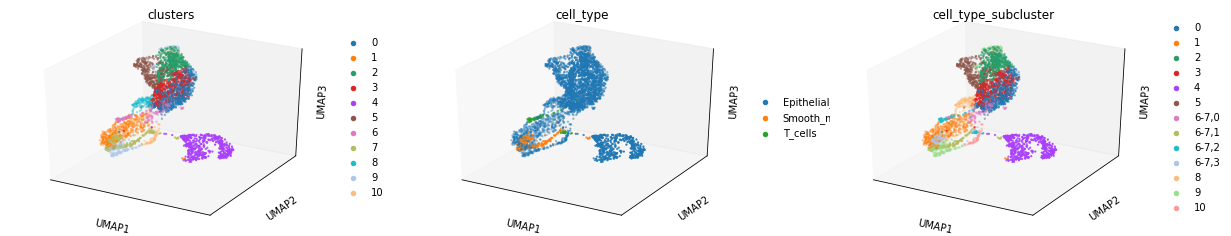

In [64]:
sc.pl.umap(adata, color=['clusters','cell_type','cell_type_subcluster'], use_raw=False)
sc.pl.umap(adata, color=['clusters','cell_type', 'cell_type_subcluster'], projection='3d',use_raw=False)

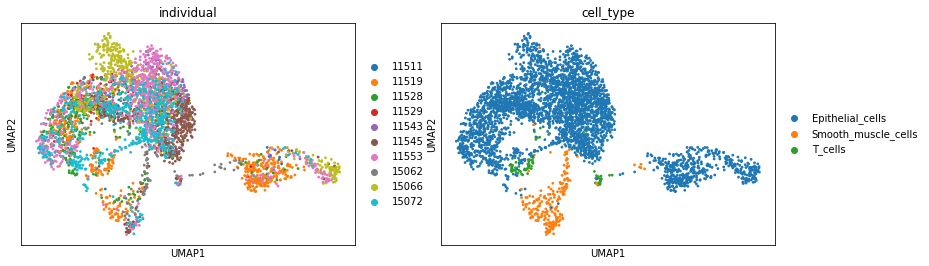

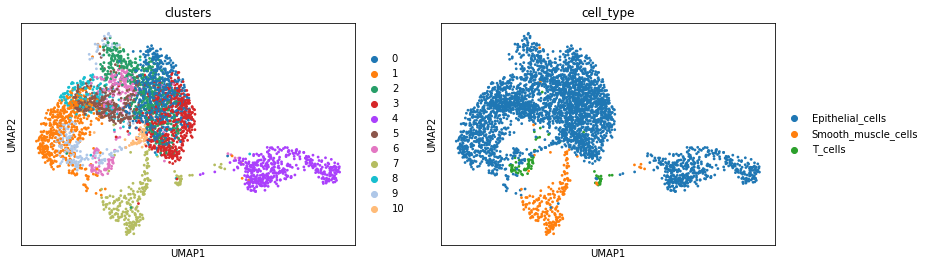

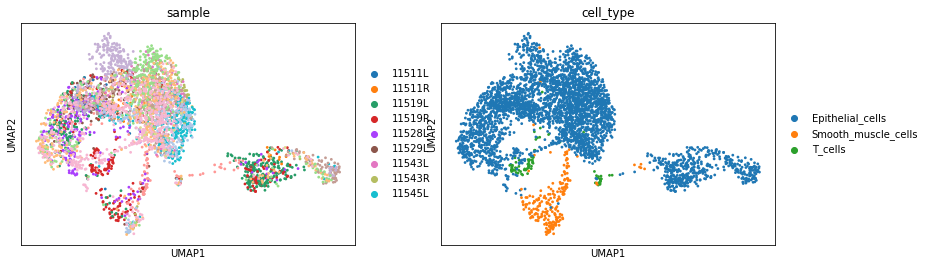

In [65]:
sc.pl.umap(adata, color=['individual','cell_type'], use_raw=False)
sc.pl.umap(adata, color=['clusters','cell_type'], use_raw=False)
sc.pl.umap(adata, color=['sample','cell_type'], use_raw=False)

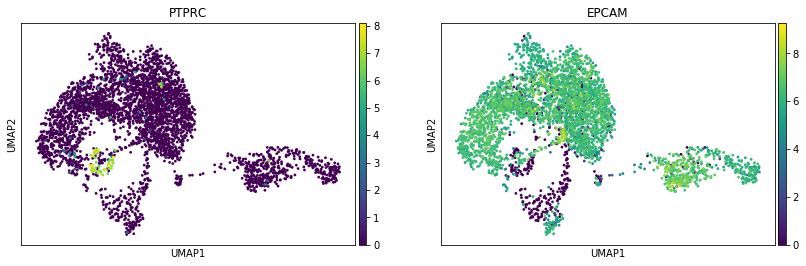

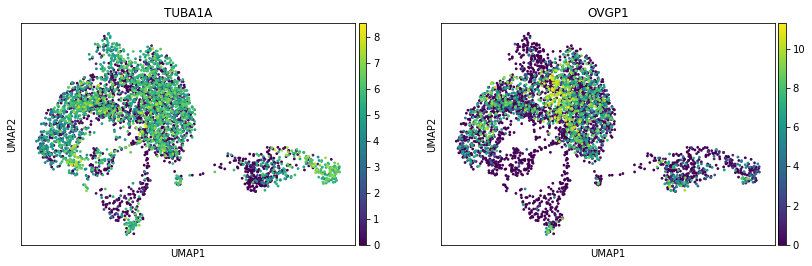

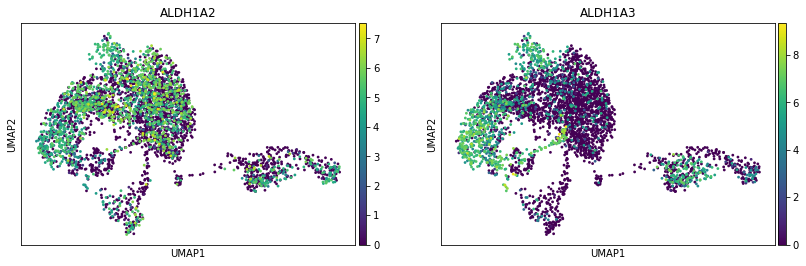

In [66]:
sc.pl.umap(adata, color=['PTPRC', 'EPCAM'], projection='2d', use_raw=False)
sc.pl.umap(adata, color=['TUBA1A', 'OVGP1'], projection='2d', use_raw=False)
sc.pl.umap(adata, color=['ALDH1A2', 'ALDH1A3'], projection='2d', use_raw=False)

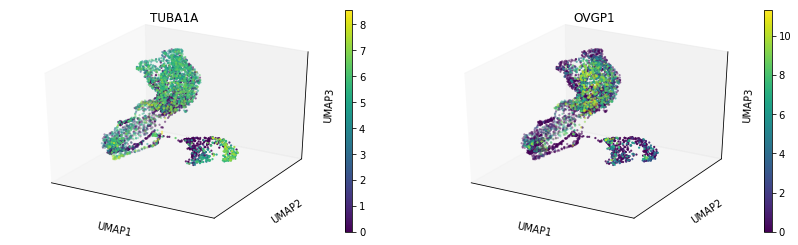

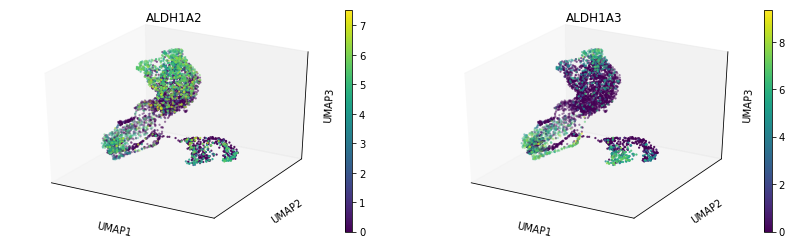

In [67]:
sc.pl.umap(adata, color=['TUBA1A', 'OVGP1'], projection='3d', use_raw=False)
sc.pl.umap(adata, color=['ALDH1A2', 'ALDH1A3'], projection='3d', use_raw=False)

# Marker Finding

In [68]:
adata.obs['cell_type_clusters']=adata.obs['cell_type'].astype('str')+'_'+adata.obs['cell_type_subcluster'].astype('str')

adata.obs[0:3]

individual  n_counts  log_counts  n_genes  mt_frac      fresh  \
11519L-P1-E10      11519  460763.0   13.040639     1740      0.0  not_fresh   
11519L-P1-F02      11519  542911.0   13.204700     2970      0.0  not_fresh   
11519L-P1-F03      11519  396958.0   12.891585     3259      0.0  not_fresh   

              tube_side  sample  size_factors clusters   S_score  G2M_score  \
11519L-P1-E10      left  11519L      0.554436        4 -0.293509  -0.318558   
11519L-P1-F02      left  11519L      0.533413        6 -0.538966  -0.036759   
11519L-P1-F03      left  11519L      0.485951        4  0.157519  -0.328214   

              phase cell_type_subcluster         cell_type  \
11519L-P1-E10    G1                    4  Epithelial_cells   
11519L-P1-F02    G1                6-7,0  Epithelial_cells   
11519L-P1-F03     S                    4  Epithelial_cells   

                   cell_type_clusters  
11519L-P1-E10      Epithelial_cells_4  
11519L-P1-F02  Epithelial_cells_6-7,0  
11519L-P1-F03      Epithelial_cells_4

... storing 'cell_type_clusters' as categorical


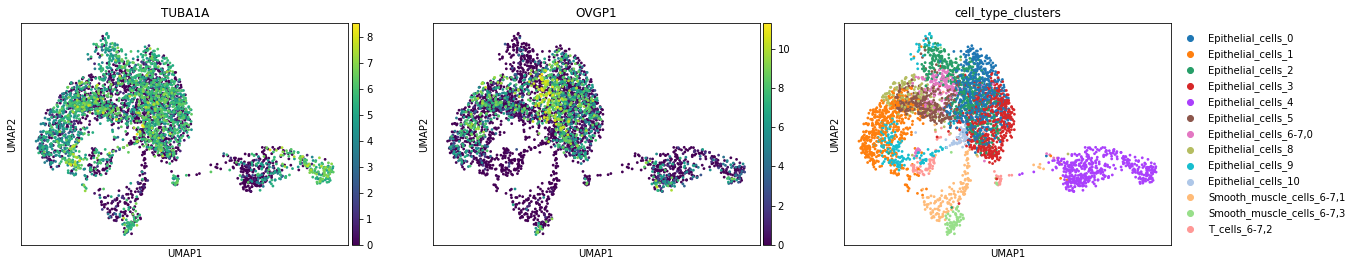

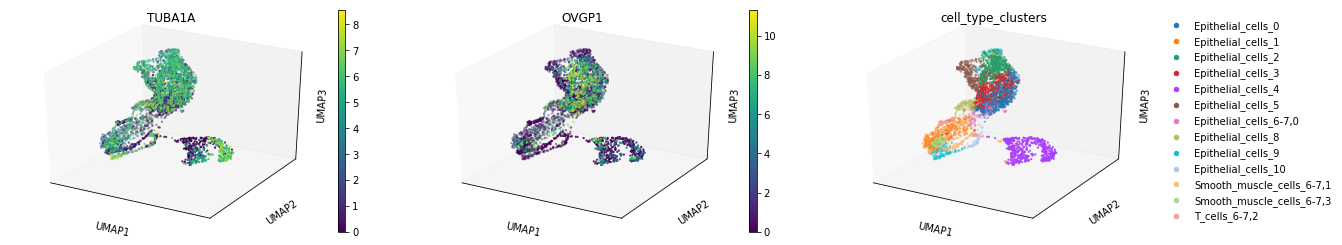

In [69]:
sc.pl.umap(adata, color=['TUBA1A', 'OVGP1','cell_type_clusters'], use_raw=False)
sc.pl.umap(adata, color=['TUBA1A', 'OVGP1','cell_type_clusters'], projection='3d',use_raw=False)

In [70]:
# rank genes by cluster
sc.tl.rank_genes_groups(adata, groupby='cell_type_clusters', key_added='rank_genes_clusters')

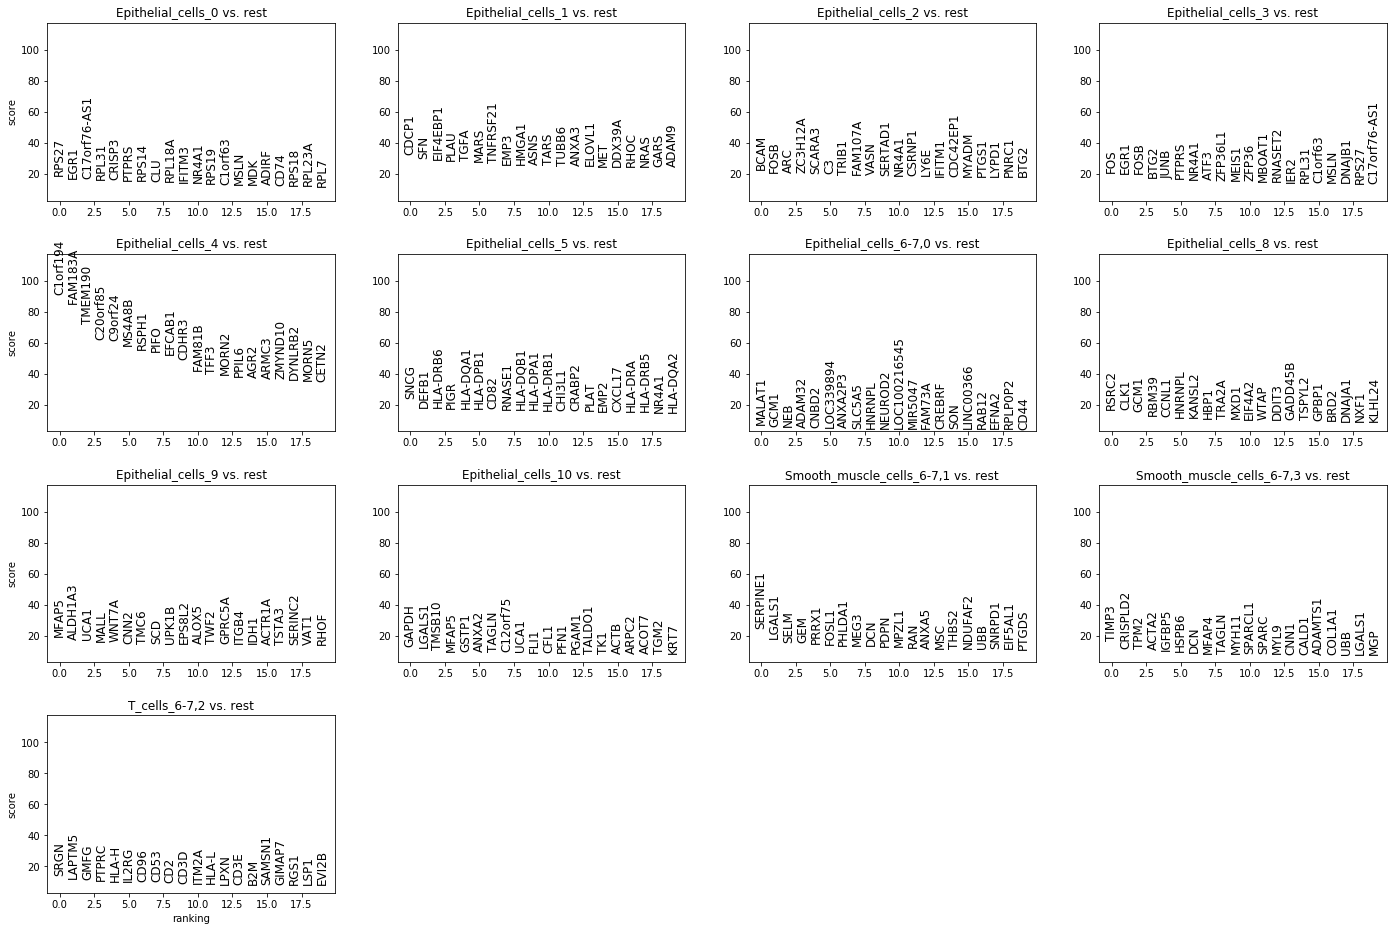

In [71]:
# plot for epithilial cluster
sc.pl.rank_genes_groups(adata, key='rank_genes_clusters', fontsize=12)

In [72]:
marker_genes=dict()
for i in adata.obs['cell_type_clusters'].unique():
    marker_genes[i]=adata.uns['rank_genes_clusters']['names'][i][0:15]

In [73]:
cell_annotation = sc.tl.marker_gene_overlap(adata, marker_genes, key='rank_genes_clusters') 
cell_annotation 

Epithelial_cells_0  Epithelial_cells_1  \
Epithelial_cells_4                        0.0                 0.0   
Epithelial_cells_6-7,0                    0.0                 0.0   
Epithelial_cells_1                        0.0                15.0   
Smooth_muscle_cells_6-7,1                 0.0                 1.0   
Epithelial_cells_0                       15.0                 0.0   
Epithelial_cells_8                        0.0                 0.0   
Epithelial_cells_3                       11.0                 0.0   
Epithelial_cells_9                        0.0                 1.0   
Epithelial_cells_10                       1.0                 2.0   
Smooth_muscle_cells_6-7,3                 0.0                 0.0   
T_cells_6-7,2                             0.0                 0.0   
Epithelial_cells_5                        2.0                 0.0   
Epithelial_cells_2                        4.0                 0.0   

                           Epithelial_cells_2  Epithelial_cells_3  \
Epithelial_cells_4                        0.0                 0.0   
Epithelial_cells_6-7,0                    0.0                 0.0   
Epithelial_cells_1                        0.0                 0.0   
Smooth_muscle_cells_6-7,1                 0.0                 0.0   
Epithelial_cells_0                        6.0                15.0   
Epithelial_cells_8                        0.0                 0.0   
Epithelial_cells_3                        9.0                15.0   
Epithelial_cells_9                        0.0                 0.0   
Epithelial_cells_10                       0.0                 0.0   
Smooth_muscle_cells_6-7,3                 0.0                 1.0   
T_cells_6-7,2                             0.0                 0.0   
Epithelial_cells_5                        6.0                 0.0   
Epithelial_cells_2                       15.0                 6.0   

                           Epithelial_cells_4  Epithelial_cells_5  \
Epithelial_cells_4                       15.0                 0.0   
Epithelial_cells_6-7,0                    0.0                 0.0   
Epithelial_cells_1                        0.0                 0.0   
Smooth_muscle_cells_6-7,1                 0.0                 0.0   
Epithelial_cells_0                        0.0                 4.0   
Epithelial_cells_8                        0.0                 0.0   
Epithelial_cells_3                        0.0                 4.0   
Epithelial_cells_9                        0.0                 0.0   
Epithelial_cells_10                       0.0                 0.0   
Smooth_muscle_cells_6-7,3                 0.0                 0.0   
T_cells_6-7,2                             0.0                 0.0   
Epithelial_cells_5                        0.0                15.0   
Epithelial_cells_2                        0.0                 7.0   

                           Epithelial_cells_6-7,0  Epithelial_cells_8  \
Epithelial_cells_4                            0.0                 0.0   
Epithelial_cells_6-7,0                       15.0                 3.0   
Epithelial_cells_1                            0.0                 0.0   
Smooth_muscle_cells_6-7,1                     1.0                 0.0   
Epithelial_cells_0                            0.0                 0.0   
Epithelial_cells_8                            3.0                15.0   
Epithelial_cells_3                            0.0                 0.0   
Epithelial_cells_9                            0.0                 0.0   
Epithelial_cells_10                           0.0                 0.0   
Smooth_muscle_cells_6-7,3                     0.0                 0.0   
T_cells_6-7,2                                 4.0                 0.0   
Epithelial_cells_5                            0.0                 0.0   
Epithelial_cells_2                            0.0                 0.0   

                           Epithelial_cells_9  Epithelial_cells_10  \
Epithelial_cells_4               

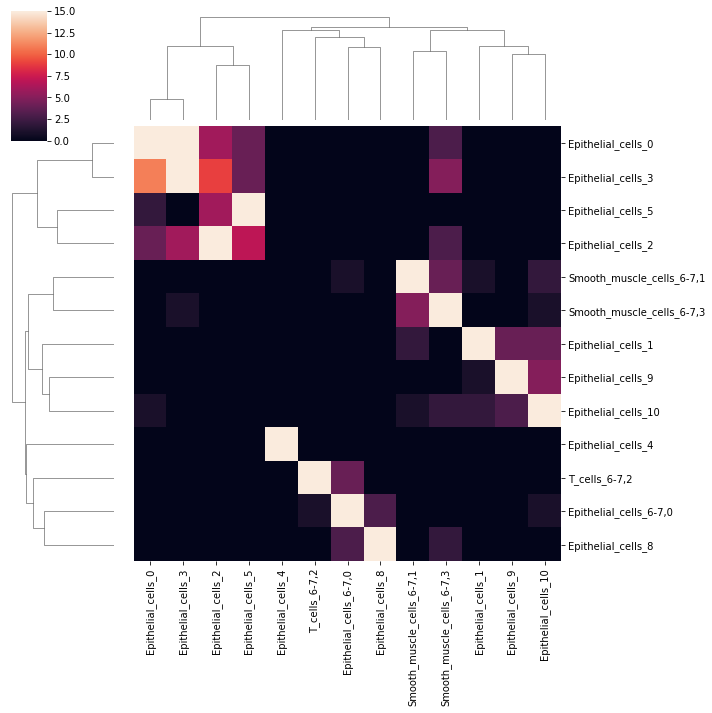

In [74]:
sns.clustermap(cell_annotation)

In [75]:
merge_dict={'Epithelial_cells_0':'Epithelial_cells_0'}

In [76]:
merge_dict={'Epithelial_cells_0':'Epithelial_cells_0', 'Epithelial_cells_3':'Epithelial_cells_0', 'Epithelial_cells_2':'Epithelial_cells_0','Epithelial_cells_5':'Epithelial_cells_0',
'Epithelial_cells_4':'Epithelial_cells_1', 'Epithelial_cells_8':'Epithelial_cells_1', 'Epithelial_cells_6-7,0':'Epithelial_cells_1',
'Epithelial_cells_1':'Epithelial_cells_2','Epithelial_cells_9':'Epithelial_cells_2', 'Epithelial_cells_10':'Epithelial_cells_2',
'T_cells_6-7,2':'T_cells_0',
'Smooth_muscle_cells_6-7,1':'Smooth_muscle_cells_0','Smooth_muscle_cells_6-7,3':'Smooth_muscle_cells_0'}

#now, re-set cell type clusters
adata.obs['cell_type_clusters']=[merge_dict[i] for i in adata.obs['cell_type_clusters']]

In [77]:
# rank genes by cluster
sc.tl.rank_genes_groups(adata, groupby='cell_type_clusters', key_added='rank_genes_clusters')

... storing 'cell_type_clusters' as categorical


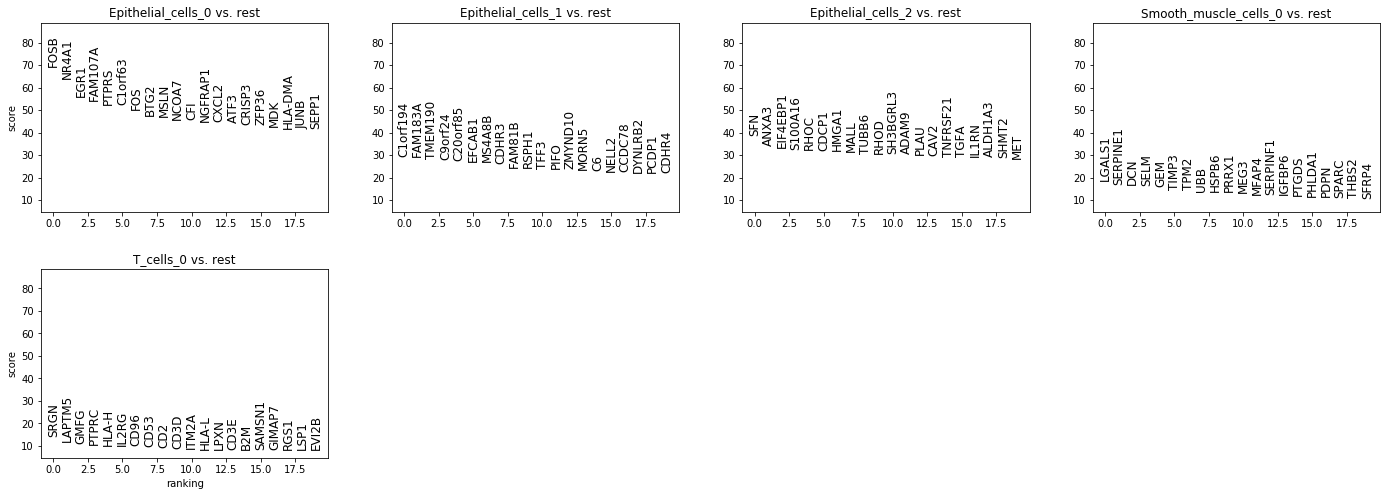

In [78]:
# plot for epithilial cluster
sc.pl.rank_genes_groups(adata, key='rank_genes_clusters', fontsize=12)

In [79]:
marker_genes=dict()
for i in adata.obs['cell_type_clusters'].unique():
    marker_genes[i]=adata.uns['rank_genes_clusters']['names'][i][0:15] 

# Deconvolution

In [80]:
for i in marker_genes.keys():
    globals()[i]=pd.DataFrame.from_dict(marker_genes['%s' %(i)]) 
    globals()[i].columns=[i]
    globals()[i].to_csv('%s.tsv' %(i), sep='\t', index=False)

In [81]:
marker_list=[]
for i in marker_genes.keys():
    marker_list.append(i+'.tsv')
    
%R -i marker_list

In [82]:
#make variables to hand to R/Bseasc
sc_counts=pd.DataFrame(adata.layers['counts'].T,columns=adata.obs.index, index=adata.var['gene_ids'])
cell_type=list(adata.obs['cell_type_clusters']) 
sample_id=sc_counts.columns

In [83]:
%%R -i sc_counts,cell_type,sample_id

library(bseqsc) #cool, at least I can load the tool
library(Biobase)

In [84]:
%%R

eset<-as.matrix(sc_counts)
rownames(eset)<-rownames(sc_counts) #convert this to ENTREZID
colnames(eset)<colnames(sc_counts)
eset<-ExpressionSet(eset)

In [85]:
%%R

eset$'cellType'<-as_vector(cell_type)
eset$'sampleID'<-as_vector(sample_id)

In [86]:
%%R

eset

ExpressionSet (storageMode: lockedEnvironment)
assayData: 20726 features, 3877 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: X11519L.P1.E10 X11519L.P1.F02 ... X15072R.p1.C03 (3877
    total)
  varLabels: cellType sampleID
  varMetadata: labelDescription
featureData: none
experimentData: use 'experimentData(object)'
Annotation:  


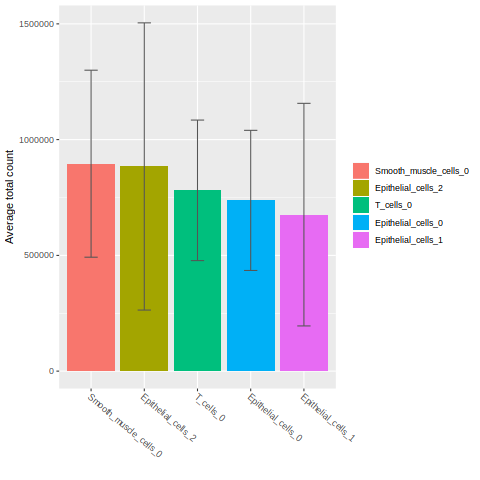

In [87]:
%%R

plotCellTotals(eset,'cellType','sampleID')

In [88]:
%%R

file_list<-as_vector(marker_list)
markers<-list()
for (i in file_list)
{
    val<-i
    #print(val)
    markers[substr(i,1,nchar(i)-4)]<-read.csv(val,sep='\t')
    #markers$substr(i,1,nchar(i)-4)<-
}

In [89]:
pheno_labels = adata.obs['cell_type_clusters']
%R -i pheno_labels

In [90]:

sc_counts = pd.DataFrame(adata.layers['counts'], 
                         index = adata.obs.index, 
                         columns = adata.var['gene_ids'])
sc_counts.head()

gene_ids       WASH7P  LOC729737  LOC100133331  LOC100288069  LINC00115  \
11519L-P1-E10     0.0        0.0           0.0           0.0        0.0   
11519L-P1-F02     0.0        0.0           0.0           0.0        0.0   
11519L-P1-F03     0.0        0.0           0.0           0.0        0.0   
11519L-P1-F06     0.0        0.0           0.0           0.0        0.0   
11519L-P1-F07     0.0        0.0           0.0           0.0        0.0   

gene_ids       LOC643837  FAM41C  SAMD11  NOC2L  KLHL17  ...  UTY  TMSB4Y  \
11519L-P1-E10        1.0     0.0     0.0    0.0     0.0  ...  0.0     0.0   
11519L-P1-F02       11.0     0.0     0.0   24.0     0.0  ...  0.0     0.0   
11519L-P1-F03        0.0     0.0     0.0    0.0     0.0  ...  0.0     0.0   
11519L-P1-F06        0.0     0.0     0.0   63.0     0.0  ...  0.0     0.0   
11519L-P1-F07        0.0     0.0     0.0    0.0     0.0  ...  0.0     0.0   

gene_ids       NLGN4Y  NLGN4Y-AS1   CD24  BCORP1  TXLNG2P  KDM5D  EIF1AY  \
11519L-P1-E10     0.0         0.0  175.0     0.0      0.0    0.0     0.0   
11519L-P1-F02     0.0         0.0    0.0     0.0      0.0    0.0     0.0   
11519L-P1-F03     0.0         0.0   94.0     0.0      0.0    0.0     0.0   
11519L-P1-F06     0.0         0.0  113.0     0.0      0.0    0.0     0.0   
11519L-P1-F07     0.0         0.0   26.0     0.0      0.0    0.0     0.0   

gene_ids       RPS4Y2  
11519L-P1-E10     0.0  
11519L-P1-F02     0.0  
11519L-P1-F03     0.0  
11519L-P1-F06     0.0  
11519L-P1-F07     0.0  

[5 rows x 20726 columns]

In [91]:
%%R -i sc_counts

head(sc_counts[0:3])

              WASH7P LOC729737 LOC100133331
11519L-P1-E10      0         0            0
11519L-P1-F02      0         0            0
11519L-P1-F03      0         0            0
11519L-P1-F06      0         0            0
11519L-P1-F07      0         0            0
11519L-P1-F08      0         0            0


In [92]:
%%R

B <- bseqsc_basis(eset, markers, clusters = 'cellType', samples = 'sampleID', ct.scale = TRUE)

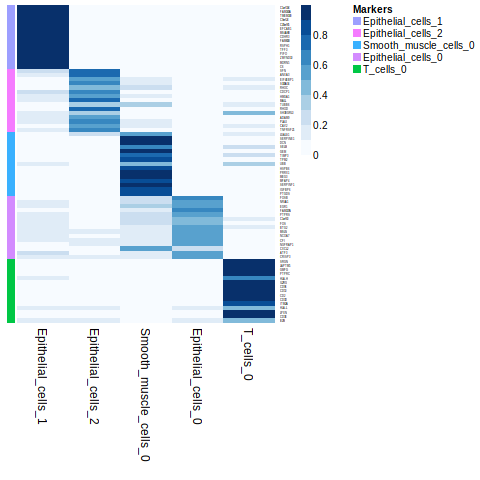

In [93]:
%%R

#check to see if the markers are good
plotBasis(B, markers, Colv = NA, Rowv = NA, col = 'Blues') 

In [94]:
#raw_counts = pd.read_csv('raw_count_matrix.tsv',sep='\t',index_col=0) 
raw_counts = pd.read_csv('counts.tsv',sep='\t',index_col=0) 
raw_counts.head()

ProxA_neg_23227  ProxA_neg_23174  ProxA_neg_26782  DistA_neg_23429  \
100287102                0                0                0                0   
653635                   0                0                0                0   
102466751                0                0                0                0   
100302278                0                0                0                0   
645520                   0                0                0                0   

           ProxA_neg_25072  ProxA_neg_28407  ProxA_neg_28327  DistA_pos_23227  \
100287102                0                0                0                0   
653635                   0                0                0                0   
102466751                0                0                0                0   
100302278                0                0                0                0   
645520                   0                0                0                0   

           ProxA_pos_23174  ProxA_pos_26782  ...  DistA_neg_28407  \
100287102                0                0  ...                0   
653635                   0                0  ...                0   
102466751                0                0  ...                0   
100302278                0                0  ...                0   
645520                   0                0  ...                0   

           DistA_neg_28327  DistA_pos_23181  ProxA_pos_23227  DistA_pos_23379  \
100287102                0                0                0                0   
653635                   0                0                0                0   
102466751                0                0                0                0   
100302278                0                0                0                0   
645520                   0                0                0                0   

           DistA_pos_25072  DistA_pos_31043  DistA_neg_31060  DistA_pos_28407  \
100287102                0                0                0                0   
653635                   0                0                0                0   
102466751                0                0                0                0   
100302278                0                0                0                0   
645520                   0                0                0                0   

           DistA_pos_28327  
100287102                0  
653635                   0  
102466751                0  
100302278                0  
645520                   0  

[5 rows x 34 columns]

In [95]:
cols = raw_counts.columns

## CIBERSORT

In [96]:
%R -i raw_counts,cols

In [97]:
%%R 

#convert the entrezID to gene symbol
raw_symbol<-as_vector(mapIds(org.Hs.eg.db,keys=rownames(raw_counts),
  column='SYMBOL',
  keytype='ENTREZID',
  multiVals='first'))

rownames(raw_counts)<-make.names(raw_symbol,unique=TRUE )

In [98]:
%%R

raw_minimal_set<-as.matrix(raw_counts)
raw_minimal_set<-ExpressionSet(raw_minimal_set)

In [99]:
R_deconvolution = links[5][0]

In [100]:
%%R -i R_deconvolution

save.image(R_deconvolution)

In [101]:
#! conda run -n SC_Env Rscript run_beseqsc_deconvolutionR.R

In [103]:
R_deconvolution_end = links[6][0]

In [104]:
%%R -i R_deconvolution_end

load(R_deconvolution_end)

#now re-load all the packages
library(slam)
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)
library(MuSiC)
library(TED)
library(edgeR)

#also useful
library(SingleR)
library(scRNAseq)
library(scater) #this is critical
library(org.Hs.eg.db)
library(purrr)

hs<-org.Hs.eg.db

## plots

In [105]:
%%R

pData(raw_minimal_set)<-cbind(pData(raw_minimal_set), t(coef(raw_fit)))

In [106]:
%%R 

#now make variables to pass back to python
raw_fit_df<-data.frame(raw_fit$coefficients)

In [107]:
%R -o raw_fit_df

In [108]:
raw_fit_df.head()

ProxA_neg_23227  ProxA_neg_23174  ProxA_neg_26782  \
Epithelial_cells_1            0.472442         0.465951         0.545696   
Epithelial_cells_2            0.000000         0.000000         0.000000   
Smooth_muscle_cells_0         0.000091         0.000000         0.000000   
Epithelial_cells_0            0.520971         0.534049         0.422624   
T_cells_0                     0.006496         0.000000         0.031680   

                       DistA_neg_23429  ProxA_neg_25072  ProxA_neg_28407  \
Epithelial_cells_1            0.352071         0.463000         0.397776   
Epithelial_cells_2            0.000000         0.000000         0.000000   
Smooth_muscle_cells_0         0.000000         0.000000         0.000000   
Epithelial_cells_0            0.647929         0.483514         0.602224   
T_cells_0                     0.000000         0.053486         0.000000   

                       ProxA_neg_28327  DistA_pos_23227  ProxA_pos_23174  \
Epithelial_cells_1            0.615223         0.410686         0.387535   
Epithelial_cells_2            0.000000         0.000000         0.000000   
Smooth_muscle_cells_0         0.000000         0.000000         0.000000   
Epithelial_cells_0            0.384777         0.589314         0.559742   
T_cells_0                     0.000000         0.000000         0.052722   

                       ProxA_pos_26782  ...  DistA_neg_28407  DistA_neg_28327  \
Epithelial_cells_1            0.584681  ...         0.317195         0.363473   
Epithelial_cells_2            0.000000  ...         0.000000         0.000000   
Smooth_muscle_cells_0         0.000000  ...         0.000000         0.000000   
Epithelial_cells_0            0.409439  ...         0.682805         0.636527   
T_cells_0                     0.005880  ...         0.000000         0.000000   

                       DistA_pos_23181  ProxA_pos_23227  DistA_pos_23379  \
Epithelial_cells_1            0.497627         0.635483         0.339542   
Epithelial_cells_2            0.000000         0.000000         0.000000   
Smooth_muscle_cells_0         0.000000         0.000000         0.000000   
Epithelial_cells_0            0.502373         0.364517         0.660458   
T_cells_0                     0.000000         0.000000         0.000000   

                       DistA_pos_25072  DistA_pos_31043  DistA_neg_31060  \
Epithelial_cells_1            0.720603         0.240835          0.36073   
Epithelial_cells_2            0.000000         0.000000          0.00000   
Smooth_muscle_cells_0         0.001829         0.000000          0.00000   
Epithelial_cells_0            0.276487         0.759165          0.63927   
T_cells_0                     0.001081         0.000000          0.00000   

                       DistA_pos_28407  DistA_pos_28327  
Epithelial_cells_1             0.29309         0.386603  
Epithelial_cells_2             0.00000         0.000000  
Smooth_muscle_cells_0          0.00000         0.000000  
Epithelial_cells_0             0.70691         0.577612  
T_cells_0                      0.00000         0.035786  

[5 rows x 34 columns]

In [109]:
raw_fit_plot=raw_fit_df.T
raw_fit_plot.head()

Epithelial_cells_1  Epithelial_cells_2  \
ProxA_neg_23227            0.472442                 0.0   
ProxA_neg_23174            0.465951                 0.0   
ProxA_neg_26782            0.545696                 0.0   
DistA_neg_23429            0.352071                 0.0   
ProxA_neg_25072            0.463000                 0.0   

                 Smooth_muscle_cells_0  Epithelial_cells_0  T_cells_0  
ProxA_neg_23227               0.000091            0.520971   0.006496  
ProxA_neg_23174               0.000000            0.534049   0.000000  
ProxA_neg_26782               0.000000            0.422624   0.031680  
DistA_neg_23429               0.000000            0.647929   0.000000  
ProxA_neg_25072               0.000000            0.483514   0.053486

In [110]:
t = pd.DataFrame(raw_fit_plot.stack()).reset_index()
t.columns = ['sample', 'cell_type', 'fraction']
t['fraction'] = t['fraction'].astype('float')
t.head()

sample              cell_type  fraction
0  ProxA_neg_23227     Epithelial_cells_1  0.472442
1  ProxA_neg_23227     Epithelial_cells_2  0.000000
2  ProxA_neg_23227  Smooth_muscle_cells_0  0.000091
3  ProxA_neg_23227     Epithelial_cells_0  0.520971
4  ProxA_neg_23227              T_cells_0  0.006496

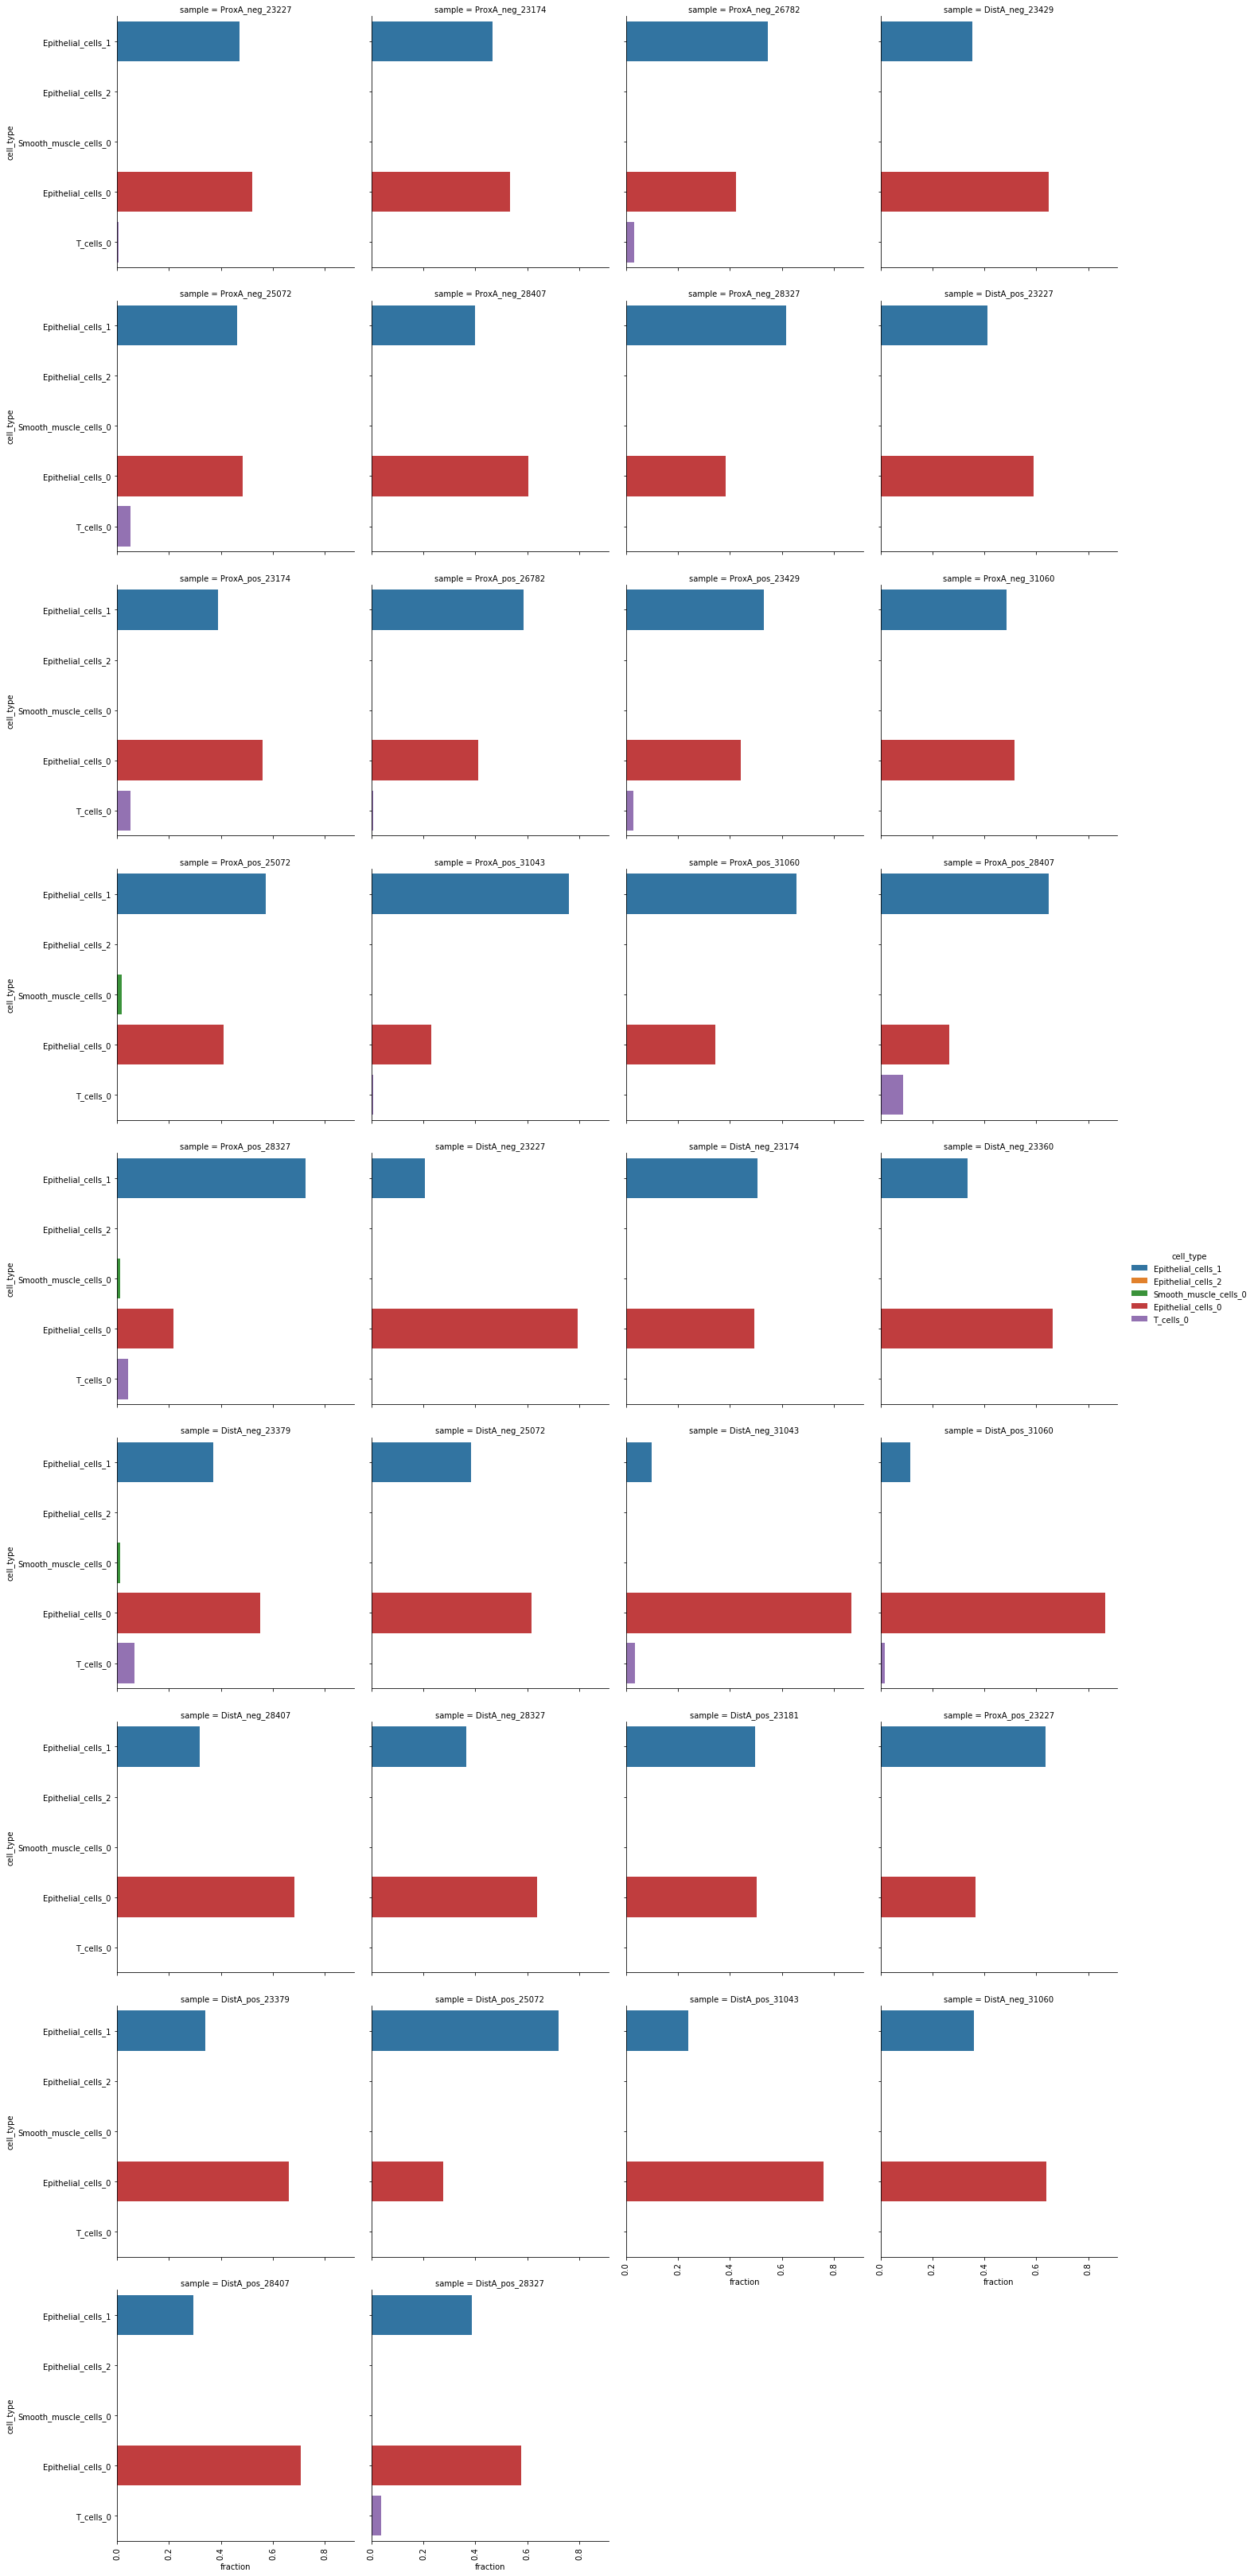

In [111]:
sns.catplot(y='cell_type', x='fraction',
            hue='cell_type',
            orient='h',
            data=t,
            col='sample',
            col_wrap=4,
            dodge=False,
            kind='bar').set_xticklabels(rotation=90)

In [112]:
revision_df = t
revision_df['sample_type'] = [i[:-6] for i in revision_df['sample']]
revision_df['individual'] = [ str(i.split('_')[-1]) for i in revision_df['sample']]
revision_df['region'] = [i.split('_')[0][0:-1] for i in revision_df['sample']]
revision_df.head()

sample              cell_type  fraction sample_type individual  \
0  ProxA_neg_23227     Epithelial_cells_1  0.472442   ProxA_neg      23227   
1  ProxA_neg_23227     Epithelial_cells_2  0.000000   ProxA_neg      23227   
2  ProxA_neg_23227  Smooth_muscle_cells_0  0.000091   ProxA_neg      23227   
3  ProxA_neg_23227     Epithelial_cells_0  0.520971   ProxA_neg      23227   
4  ProxA_neg_23227              T_cells_0  0.006496   ProxA_neg      23227   

  region  
0   Prox  
1   Prox  
2   Prox  
3   Prox  
4   Prox

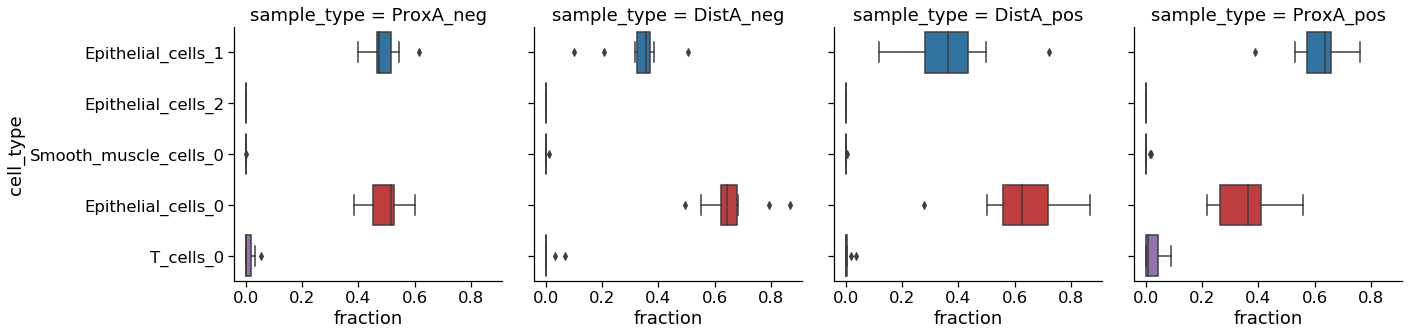

In [113]:
with sns.plotting_context('notebook', font_scale=1.5):
    g=sns.catplot(y='cell_type', x='fraction', kind='box', col='sample_type', data=revision_df)

In [114]:
from collections import OrderedDict
marker_dict = OrderedDict([('23227', 'o'),
             ('23174', 's'),
             ('23360', 'v'),
             ('23181', 'p'),
             ('26782', 'P'),
             ('23429', 'H'),
             ('28407', 'd'),
             ('25072', '^'),
             ('28327', '<'),
             ('31060', '>'),
             ('31043', 'h'),
             ('23379', 'D')])

In [115]:
revision_df['marker'] = [marker_dict[i] for i in revision_df['individual']]

In [116]:
from matplotlib import cm
viridis = cm.get_cmap('viridis', 20)
fuu2=viridis(np.linspace(-1, 1, 20))

from matplotlib import cm
fuu= cm.get_cmap('viridis', 4)
cm.register_cmap(name='fuu', cmap=fuu)

color_dict={'ProxAneg':viridis(0),
           'ProxApos':viridis(.25),
           'DistAneg':viridis(.99),
           'DistApos':viridis(.7)}

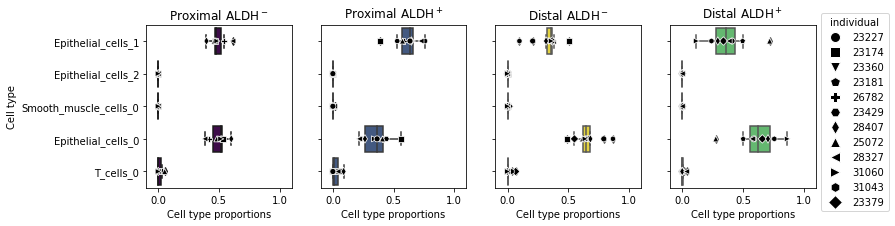

In [117]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey='row',sharex='col',  figsize=(12,3))
#f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey='row',sharex='col')

sns.boxplot(x='fraction', y='cell_type', data=revision_df[revision_df['sample_type']=='ProxA_neg'],dodge=False, ax=ax1,zorder=1, color=color_dict['ProxAneg'] ).set_title('Proximal ALDH$^-$')

sns.boxplot(x='fraction', y='cell_type', data=revision_df[revision_df['sample_type']=='ProxA_pos'],dodge=False, ax=ax2,zorder=1, color=color_dict['ProxApos'] ).set_title('Proximal ALDH$^+$')

sns.boxplot(x='fraction', y='cell_type', data=revision_df[revision_df['sample_type']=='DistA_neg'],dodge=False, ax=ax3,zorder=1, color=color_dict['DistAneg'] ).set_title('Distal ALDH$^-$')

sns.boxplot(x='fraction', y='cell_type', data=revision_df[revision_df['sample_type']=='DistA_pos'],dodge=False, ax=ax4,zorder=1, color=color_dict['DistApos'] ).set_title('Distal ALDH$^+$')

sns.scatterplot(x='fraction', y='cell_type',style='individual',markers=marker_dict ,data=revision_df[revision_df['sample_type']=='ProxA_neg'], ax=ax1, legend=False, color='k',zorder=2 ).set_xlim(-.1,1.1)#.set_xlim(0,1)#.set_xlabel('Cell type proportions')

sns.scatterplot(x='fraction', y='cell_type', style='individual',markers=marker_dict,data=revision_df[revision_df['sample_type']=='ProxA_pos'], ax=ax2, legend=False, color='k',zorder=2 ).set_xlim(-.1,1.1)#.set_xlim(-.1,1.1)#.set_xlim(-.10,1.1)#.set_xlabel('Cell type proportions')

sns.scatterplot(x='fraction', y='cell_type', style='individual',markers=marker_dict,data=revision_df[revision_df['sample_type']=='DistA_neg'], ax=ax3, legend=False, color='k',zorder=2 ).set_xlim(-.1,1.1)#.set_xlim(0,1)#.set_xlabel('Cell type proportions')

sns.scatterplot(x='fraction', y='cell_type', style='individual',markers=marker_dict,data=revision_df[revision_df['sample_type']=='DistA_pos'], ax=ax4, legend=False, color='k',zorder=2 ).set_xlim(-.1,1.1)#.set_xlim(0,1)
ax1.set_xlabel('Cell type proportions')
ax2.set_xlabel('Cell type proportions')
ax3.set_xlabel('Cell type proportions')
ax4.set_xlabel('Cell type proportions')
ax1.set_ylabel('Cell type')
# legend
labels=marker_dict.keys()
custom_lines=[Line2D([0], [0],marker=marker_dict[i],markeredgecolor='white', color='k', lw=0,markersize=10) for i in marker_dict.keys()]

plt.legend(custom_lines, labels,loc='upper left', bbox_to_anchor=(1, 1.1), title='individual')

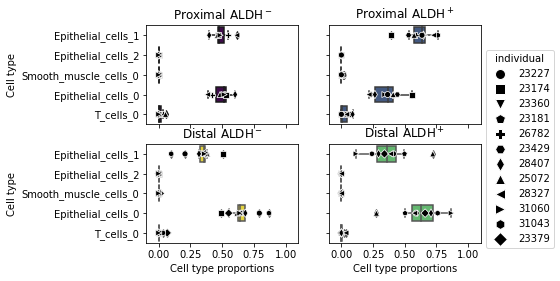

In [118]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey='row',sharex='col')
sns.boxplot(x='fraction', y='cell_type', data=revision_df[revision_df['sample_type']=='ProxA_neg'],dodge=False, ax=ax1,zorder=1, color=color_dict['ProxAneg'] ).set_title('Proximal ALDH$^-$')

sns.boxplot(x='fraction', y='cell_type', data=revision_df[revision_df['sample_type']=='ProxA_pos'],dodge=False, ax=ax2,zorder=1, color=color_dict['ProxApos'] ).set_title('Proximal ALDH$^+$')

sns.boxplot(x='fraction', y='cell_type', data=revision_df[revision_df['sample_type']=='DistA_neg'],dodge=False, ax=ax3,zorder=1, color=color_dict['DistAneg'] ).set_title('Distal ALDH$^-$')

sns.boxplot(x='fraction', y='cell_type', data=revision_df[revision_df['sample_type']=='DistA_pos'],dodge=False, ax=ax4,zorder=1, color=color_dict['DistApos'] ).set_title('Distal ALDH$^+$')

sns.scatterplot(x='fraction', y='cell_type',style='individual',markers=marker_dict ,data=revision_df[revision_df['sample_type']=='ProxA_neg'], ax=ax1, legend=False, color='k',zorder=2 ).set_xlim(-.1,1.1)#.set_xlim(0,1)#.set_xlabel('Cell type proportions')

sns.scatterplot(x='fraction', y='cell_type', style='individual',markers=marker_dict,data=revision_df[revision_df['sample_type']=='ProxA_pos'], ax=ax2, legend=False, color='k',zorder=2 ).set_xlim(-.1,1.1)#.set_xlim(-.1,1.1)#.set_xlim(-.10,1.1)#.set_xlabel('Cell type proportions')

sns.scatterplot(x='fraction', y='cell_type', style='individual',markers=marker_dict,data=revision_df[revision_df['sample_type']=='DistA_neg'], ax=ax3, legend=False, color='k',zorder=2 ).set_xlim(-.1,1.1)#.set_xlim(0,1)#.set_xlabel('Cell type proportions')

sns.scatterplot(x='fraction', y='cell_type', style='individual',markers=marker_dict,data=revision_df[revision_df['sample_type']=='DistA_pos'], ax=ax4, legend=False, color='k',zorder=2 ).set_xlim(-.1,1.1)#.set_xlim(0,1)
ax1.set_xlabel('Cell type proportions')
ax2.set_xlabel('Cell type proportions')
ax3.set_xlabel('Cell type proportions')
ax4.set_xlabel('Cell type proportions')
ax1.set_ylabel('Cell type')
ax3.set_ylabel('Cell type')
# legend
labels=marker_dict.keys()
custom_lines=[Line2D([0], [0],marker=marker_dict[i],markeredgecolor='white', color='k', lw=0,markersize=10) for i in marker_dict.keys()]

plt.legend(custom_lines, labels,loc='upper left', bbox_to_anchor=(1, 2.0), title='individual')

# Differential expression with edgeR 

In [119]:
# make correct data frame and pass to R
bind_dict={'sample':raw_counts.columns,
          'ALDH':[i[6:9] for i in raw_counts.columns],
          'individual':[i[10::] for i in raw_counts.columns],
          'side':[i[0:4] for i in raw_counts.columns],
          'conds':[i.split('_')[0]+i.split('_')[1] for i in raw_counts.columns]}

bind_df=pd.DataFrame.from_dict(bind_dict)
bind_df.head()

sample ALDH individual  side     conds
0  ProxA_neg_23227  neg      23227  Prox  ProxAneg
1  ProxA_neg_23174  neg      23174  Prox  ProxAneg
2  ProxA_neg_26782  neg      26782  Prox  ProxAneg
3  DistA_neg_23429  neg      23429  Dist  DistAneg
4  ProxA_neg_25072  neg      25072  Prox  ProxAneg

In [120]:
%%R -i bind_df

rownames(bind_df)<-bind_df$sample
bind_df<-subset(bind_df, select=-c(sample))

head(bind_df)

                ALDH individual side    conds
ProxA_neg_23227  neg      23227 Prox ProxAneg
ProxA_neg_23174  neg      23174 Prox ProxAneg
ProxA_neg_26782  neg      26782 Prox ProxAneg
DistA_neg_23429  neg      23429 Dist DistAneg
ProxA_neg_25072  neg      25072 Prox ProxAneg
ProxA_neg_28407  neg      28407 Prox ProxAneg


In [121]:
%%R

pData(raw_minimal_set)<-cbind(pData(raw_minimal_set), bind_df)

In [122]:
%%R

design<-model.matrix(~0+Smooth_muscle_cells_0+T_cells_0+side, data=pData(raw_minimal_set))
colnames(design)<-gsub("group","",colnames(design))

contr.matrix <- makeContrasts(
    side_contrast=sideProx-sideDist,
    levels=colnames(design))

In [123]:
%%R

design<-model.matrix(~0+Smooth_muscle_cells_0+T_cells_0+side, data=pData(raw_minimal_set))

colnames(design)<-gsub("group","",colnames(design))

contr.matrix <- makeContrasts(
    side_contrast=sideProx-sideDist,
    levels=colnames(design))

esetA <- raw_minimal_set[, rownames(design)]
y <- DGEList(counts = exprs(esetA), genes = fData(esetA))
y <- calcNormFactors(y)
y <- estimateDisp(y, design)
fit <- glmQLFit(y, design)
#qlf <- glmQLFTest(fit, coef = c('condsProxAneg','condsProxApos'))
qlf <- glmQLFTest(fit, contrast=contr.matrix)
top <- topTags(qlf, n = Inf)
top$fit <- fit
fit_edger_ext<-top

In [124]:
%%R

lrt<-glmQLFTest(fit, coef='T_cells_0')

topTags(lrt)

Coefficient:  T_cells_0 
              logFC   logCPM         F       PValue        FDR
NWD2      59.144372 3.999220  86.37801 8.072552e-07 0.02292201
RAB22A    16.753820 5.640952  35.53083 3.575630e-05 0.50765001
SLC7A3    48.445026 3.942460 115.43880 5.996309e-05 0.56755061
B2M        8.645997 9.344661  18.68729 1.453741e-04 0.87328720
FBLN2    -58.293126 4.227809  18.44153 1.575997e-04 0.87328720
PDRG1    -41.170107 4.622894  21.62993 1.845298e-04 0.87328720
LRFN2    -51.771085 4.449055  15.04218 5.053516e-04 1.00000000
UBE2G2   -20.191662 5.419096  28.47864 5.854038e-04 1.00000000
SLC22A17  41.667557 3.981290  30.44481 7.058348e-04 1.00000000
SEMA6A    19.622063 4.910342  13.68518 8.271546e-04 1.00000000


In [125]:
%%R

top_tags<-topTags(lrt)$table

In [126]:
%R -o top_tags

top_tags['genes']=top_tags.index
top_tags['logp']=-np.log(top_tags['FDR'])
top_tags.head()

logFC    logCPM           F        PValue       FDR   genes  \
NWD2    59.144372  3.999220   86.378006  8.072552e-07  0.022922    NWD2   
RAB22A  16.753820  5.640952   35.530825  3.575630e-05  0.507650  RAB22A   
SLC7A3  48.445026  3.942460  115.438800  5.996309e-05  0.567551  SLC7A3   
B2M      8.645997  9.344661   18.687290  1.453741e-04  0.873287     B2M   
FBLN2  -58.293126  4.227809   18.441533  1.575997e-04  0.873287   FBLN2   

            logp  
NWD2    3.775658  
RAB22A  0.677963  
SLC7A3  0.566425  
B2M     0.135491  
FBLN2   0.135491

Text(0.5, 0.98, 'T-cells')

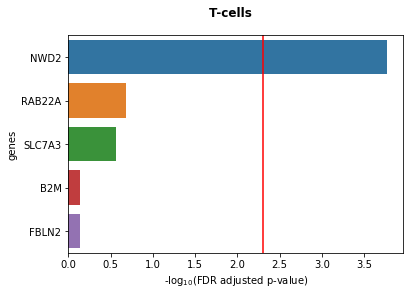

In [127]:
sns.barplot(x='logp', y='genes', data=top_tags[0:5])
plt.axvline(-np.log(0.10), c='red')
plt.xlabel(r'-log$_{10}$(FDR adjusted p-value)')
plt.suptitle('T-cells', weight='bold')

In [128]:
%%R

lrt<-glmQLFTest(fit, coef='Smooth_muscle_cells_0')

topTags(lrt)

Coefficient:  Smooth_muscle_cells_0 
            logFC   logCPM            F       PValue          FDR
LRFN2   243.90623 4.449055 5.306747e+01 3.188941e-08 0.0009054999
FBLN2   244.32342 4.227809 2.912772e+01 6.676094e-06 0.0947838485
ADPRHL1 217.49933 3.901990 4.137278e+07 6.248899e-05 0.5914583002
IRS2     71.85298 6.170447 1.926231e+01 1.205527e-04 0.8557732164
TIMP3    92.59491 6.198161 1.736064e+01 2.260059e-04 1.0000000000
NMRAL1  116.87080 4.595990 2.968182e+01 2.995646e-04 1.0000000000
OSBPL5  161.51787 4.245166 1.631277e+01 3.888665e-04 1.0000000000
ZNF781  200.32835 3.901902 5.552540e+09 4.181313e-04 1.0000000000
BCL2L10 175.43428 4.054989 1.847656e+01 7.568953e-04 1.0000000000
MDFI    199.07257 3.942154 2.662988e+01 7.610046e-04 1.0000000000


In [129]:
%%R

top_tags<-topTags(lrt)$table

In [130]:
%R -o top_tags

top_tags['genes']=top_tags.index
top_tags['logp']=-np.log(top_tags['FDR'])
top_tags.head()

logFC    logCPM             F        PValue       FDR    genes  \
LRFN2    243.906232  4.449055  5.306747e+01  3.188941e-08  0.000905    LRFN2   
FBLN2    244.323421  4.227809  2.912772e+01  6.676094e-06  0.094784    FBLN2   
ADPRHL1  217.499333  3.901990  4.137278e+07  6.248899e-05  0.591458  ADPRHL1   
IRS2      71.852984  6.170447  1.926231e+01  1.205527e-04  0.855773     IRS2   
TIMP3     92.594905  6.198161  1.736064e+01  2.260059e-04  1.000000    TIMP3   

             logp  
LRFN2    7.007023  
FBLN2    2.356156  
ADPRHL1  0.525164  
IRS2     0.155750  
TIMP3   -0.000000

Text(0.5, 0.98, 'Smooth muscle cells')

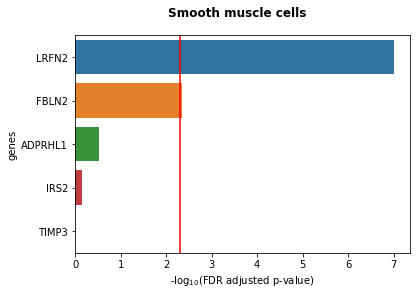

In [131]:
sns.barplot(x='logp', y='genes', data=top_tags[0:5])
plt.axvline(-np.log(0.10), c='red')
plt.xlabel(r'-log$_{10}$(FDR adjusted p-value)')
plt.suptitle('Smooth muscle cells', weight='bold')